<p style="align: center;"><img align=center src="https://s8.hostingkartinok.com/uploads/images/2018/08/308b49fcfbc619d629fe4604bceb67ac.jpg" width=500 height=450/></p>

<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Продвинутый поток. Весна 2022</b></h3>
<h3 style="text-align: center;"><b>Выполнил Кирилл Сетдеков</b></h3>

Это домашнее задание будет посвящено полноценному решению задачи машинного обучения.

Есть две части этого домашнего задания: 
* Сделать полноценный отчет о вашей работе: как вы обработали данные, какие модели попробовали и какие результаты получились (максимум 10 баллов). За каждую выполненную часть будет начислено определенное количество баллов.
* Лучшее решение отправить в соревнование на [kaggle](https://www.kaggle.com/c/advanced-dls-spring-2021/) (максимум 5 баллов). За прохождение определенного порогов будут начисляться баллы.


**Обе части будут проверяться в формате peer-review. Т.е. вашу посылку на степик будут проверять несколько других студентов и аггрегация их оценок будет выставлена. В то же время вам тоже нужно будет проверить несколько других учеников.**

**Пожалуйста, делайте свою работу чистой и понятной, чтобы облегчить проверку. Если у вас будут проблемы с решением или хочется совета, то пишите в наш чат в телеграме или в лс @runfme. Если вы захотите проаппелировать оценку, то пипшите в лс @runfme.**

**Во всех пунктах указания это минимальный набор вещей, которые стоит сделать. Если вы можете сделать какой-то шаг лучше или добавить что-то свое - дерзайте!**

# Как проверять?

Ставьте полный балл, если выполнены все рекомендации или сделано что-то более интересное и сложное. За каждый отсустствующий пункт из рекомендация снижайте 1 балл.

## imports

In [1]:
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import PowerTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import  GridSearchCV
from sklearn.preprocessing import  OneHotEncoder
from sklearn.pipeline import make_pipeline

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn import set_config

from sklearn.model_selection import train_test_split
import catboost
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
np.random.seed(40)

# Метрика

Перед решением любой задачи важно понимать, как будет оцениваться ваше решение. В данном случае мы используем стандартную для задачи классификации метрику ROC-AUC. Ее можно вычислить используя только предсказанные вероятности и истинные классы без конкретного порога классификации + она раотает даже если классы в данных сильно несбалансированны (примеров одного класса в десятки раз больше примеров длугого). Именно поэтому она очень удобна для соревнований.

Посчитать ее легко:


In [2]:
y_true = [
    0,
    1,
    1,
    0,
    1
]

y_predictions = [
    0.1,
    0.9,
    0.4,
    0.6,
    0.61
]

roc_auc_score(y_true, y_predictions)

0.8333333333333333

# Первая часть. Исследование

## Загрузка данных (2 балла)

1) Посмотрите на случайные строчки. 

2) Посмотрите, есть ли в датасете незаполненные значения (nan'ы) с помощью data.isna() или data.info() и, если нужно, замените их на что-то. Будет хорошо, если вы построите табличку с количеством nan в каждой колонке.

In [3]:
data = pd.read_csv('train.csv')

In [4]:
# Для вашего удобства списки с именами разных колонок

# Числовые признаки
num_cols = [
    'ClientPeriod',
    'MonthlySpending',
    'TotalSpent'
]

# Категориальные признаки
cat_cols = [
    'Sex',
    'IsSeniorCitizen',
    'HasPartner',
    'HasChild',
    'HasPhoneService',
    'HasMultiplePhoneNumbers',
    'HasInternetService',
    'HasOnlineSecurityService',
    'HasOnlineBackup',
    'HasDeviceProtection',
    'HasTechSupportAccess',
    'HasOnlineTV',
    'HasMovieSubscription',
    'HasContractPhone',
    'IsBillingPaperless',
    'PaymentMethod'
]

feature_cols = num_cols + cat_cols
target_col = 'Churn'

In [5]:
data.sample(5)

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
5124,63,79.85,4861.45,Female,0,No,No,Yes,Yes,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,Yes,Credit card (automatic),0
1257,30,99.70,2967.35,Female,1,No,No,Yes,Yes,Fiber optic,No,Yes,No,No,Yes,Yes,Month-to-month,Yes,Electronic check,1
866,70,26.05,1856.4,Female,0,No,No,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,No,Credit card (automatic),0
1523,1,50.10,50.1,Female,0,No,No,Yes,Yes,DSL,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,0
5150,62,48.70,3008.55,Female,0,Yes,Yes,No,No phone service,DSL,Yes,Yes,No,Yes,Yes,No,Two year,No,Bank transfer (automatic),0


Данные есть, числа - смесь float и int, возможно какие-то лучше будет преобразовать в категориальные переменные. Качественные признаки содержат не только ответы Yes/No, но и дополнительные категории

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5282 entries, 0 to 5281
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ClientPeriod              5282 non-null   int64  
 1   MonthlySpending           5282 non-null   float64
 2   TotalSpent                5282 non-null   object 
 3   Sex                       5282 non-null   object 
 4   IsSeniorCitizen           5282 non-null   int64  
 5   HasPartner                5282 non-null   object 
 6   HasChild                  5282 non-null   object 
 7   HasPhoneService           5282 non-null   object 
 8   HasMultiplePhoneNumbers   5282 non-null   object 
 9   HasInternetService        5282 non-null   object 
 10  HasOnlineSecurityService  5282 non-null   object 
 11  HasOnlineBackup           5282 non-null   object 
 12  HasDeviceProtection       5282 non-null   object 
 13  HasTechSupportAccess      5282 non-null   object 
 14  HasOnlin

In [7]:
data.isna().sum()

ClientPeriod                0
MonthlySpending             0
TotalSpent                  0
Sex                         0
IsSeniorCitizen             0
HasPartner                  0
HasChild                    0
HasPhoneService             0
HasMultiplePhoneNumbers     0
HasInternetService          0
HasOnlineSecurityService    0
HasOnlineBackup             0
HasDeviceProtection         0
HasTechSupportAccess        0
HasOnlineTV                 0
HasMovieSubscription        0
HasContractPhone            0
IsBillingPaperless          0
PaymentMethod               0
Churn                       0
dtype: int64

Пока выглядит, что пропусков нет и их не будем заменять

## Анализ данных (3 балла)

1) Для численных призанков постройте гистограмму (*plt.hist(...)*) или boxplot (*plt.boxplot(...)*). Для категориальных посчитайте количество каждого значения для каждого признака. Для каждой колонки надо сделать *data.value_counts()* и построить bar диаграммы *plt.bar(...)* или круговые диаграммы *plt.pie(...)* (хорошо, елси вы сможете это сделать на одном гарфике с помощью *plt.subplots(...)*). 

2) Посмотрите на распределение целевой переменной и скажите, являются ли классы несбалансированными.

3) (Если будет желание) Поиграйте с разными библиотеками для визуализации - *sns*, *pandas_visual_analysis*, etc.

Второй пункт очень важен, потому что существуют задачи классификации с несбалансированными классами. Например, это может значить, что в датасете намного больше примеров 0 класса. В таких случаях нужно 1) не использовать accuracy как метрику 2) использовать методы борьбы с imbalanced dataset (обычно если датасет сильно несбалансирован, т.е. класса 1 в 20 раз меньше класса 0).

In [8]:
# TotalSpent было тектовым значение с пропусками, заменим на 0 значение " " и сохраним как float
data.TotalSpent = pd.to_numeric(data.TotalSpent.replace(" ", 0))

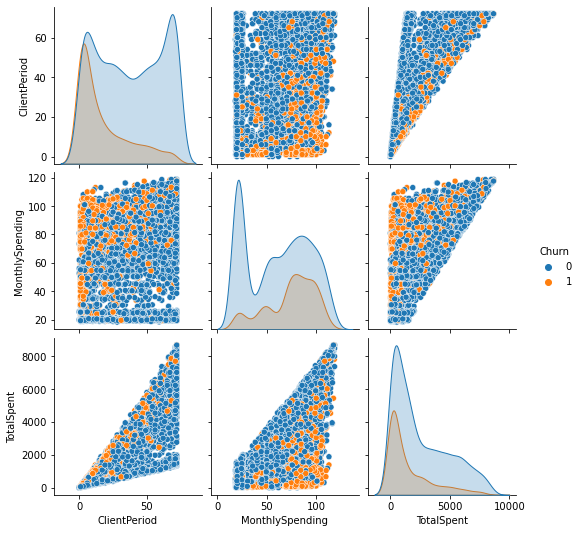

In [9]:
sns.pairplot(data[[*num_cols, 'Churn']], hue='Churn')

С числовыми признаками все нормально - по каждому распределение на глаз отличается для разных значений целевого класса, возможны проблеммы с корреляцией призанаков, но на этом этапе трогать не буду.

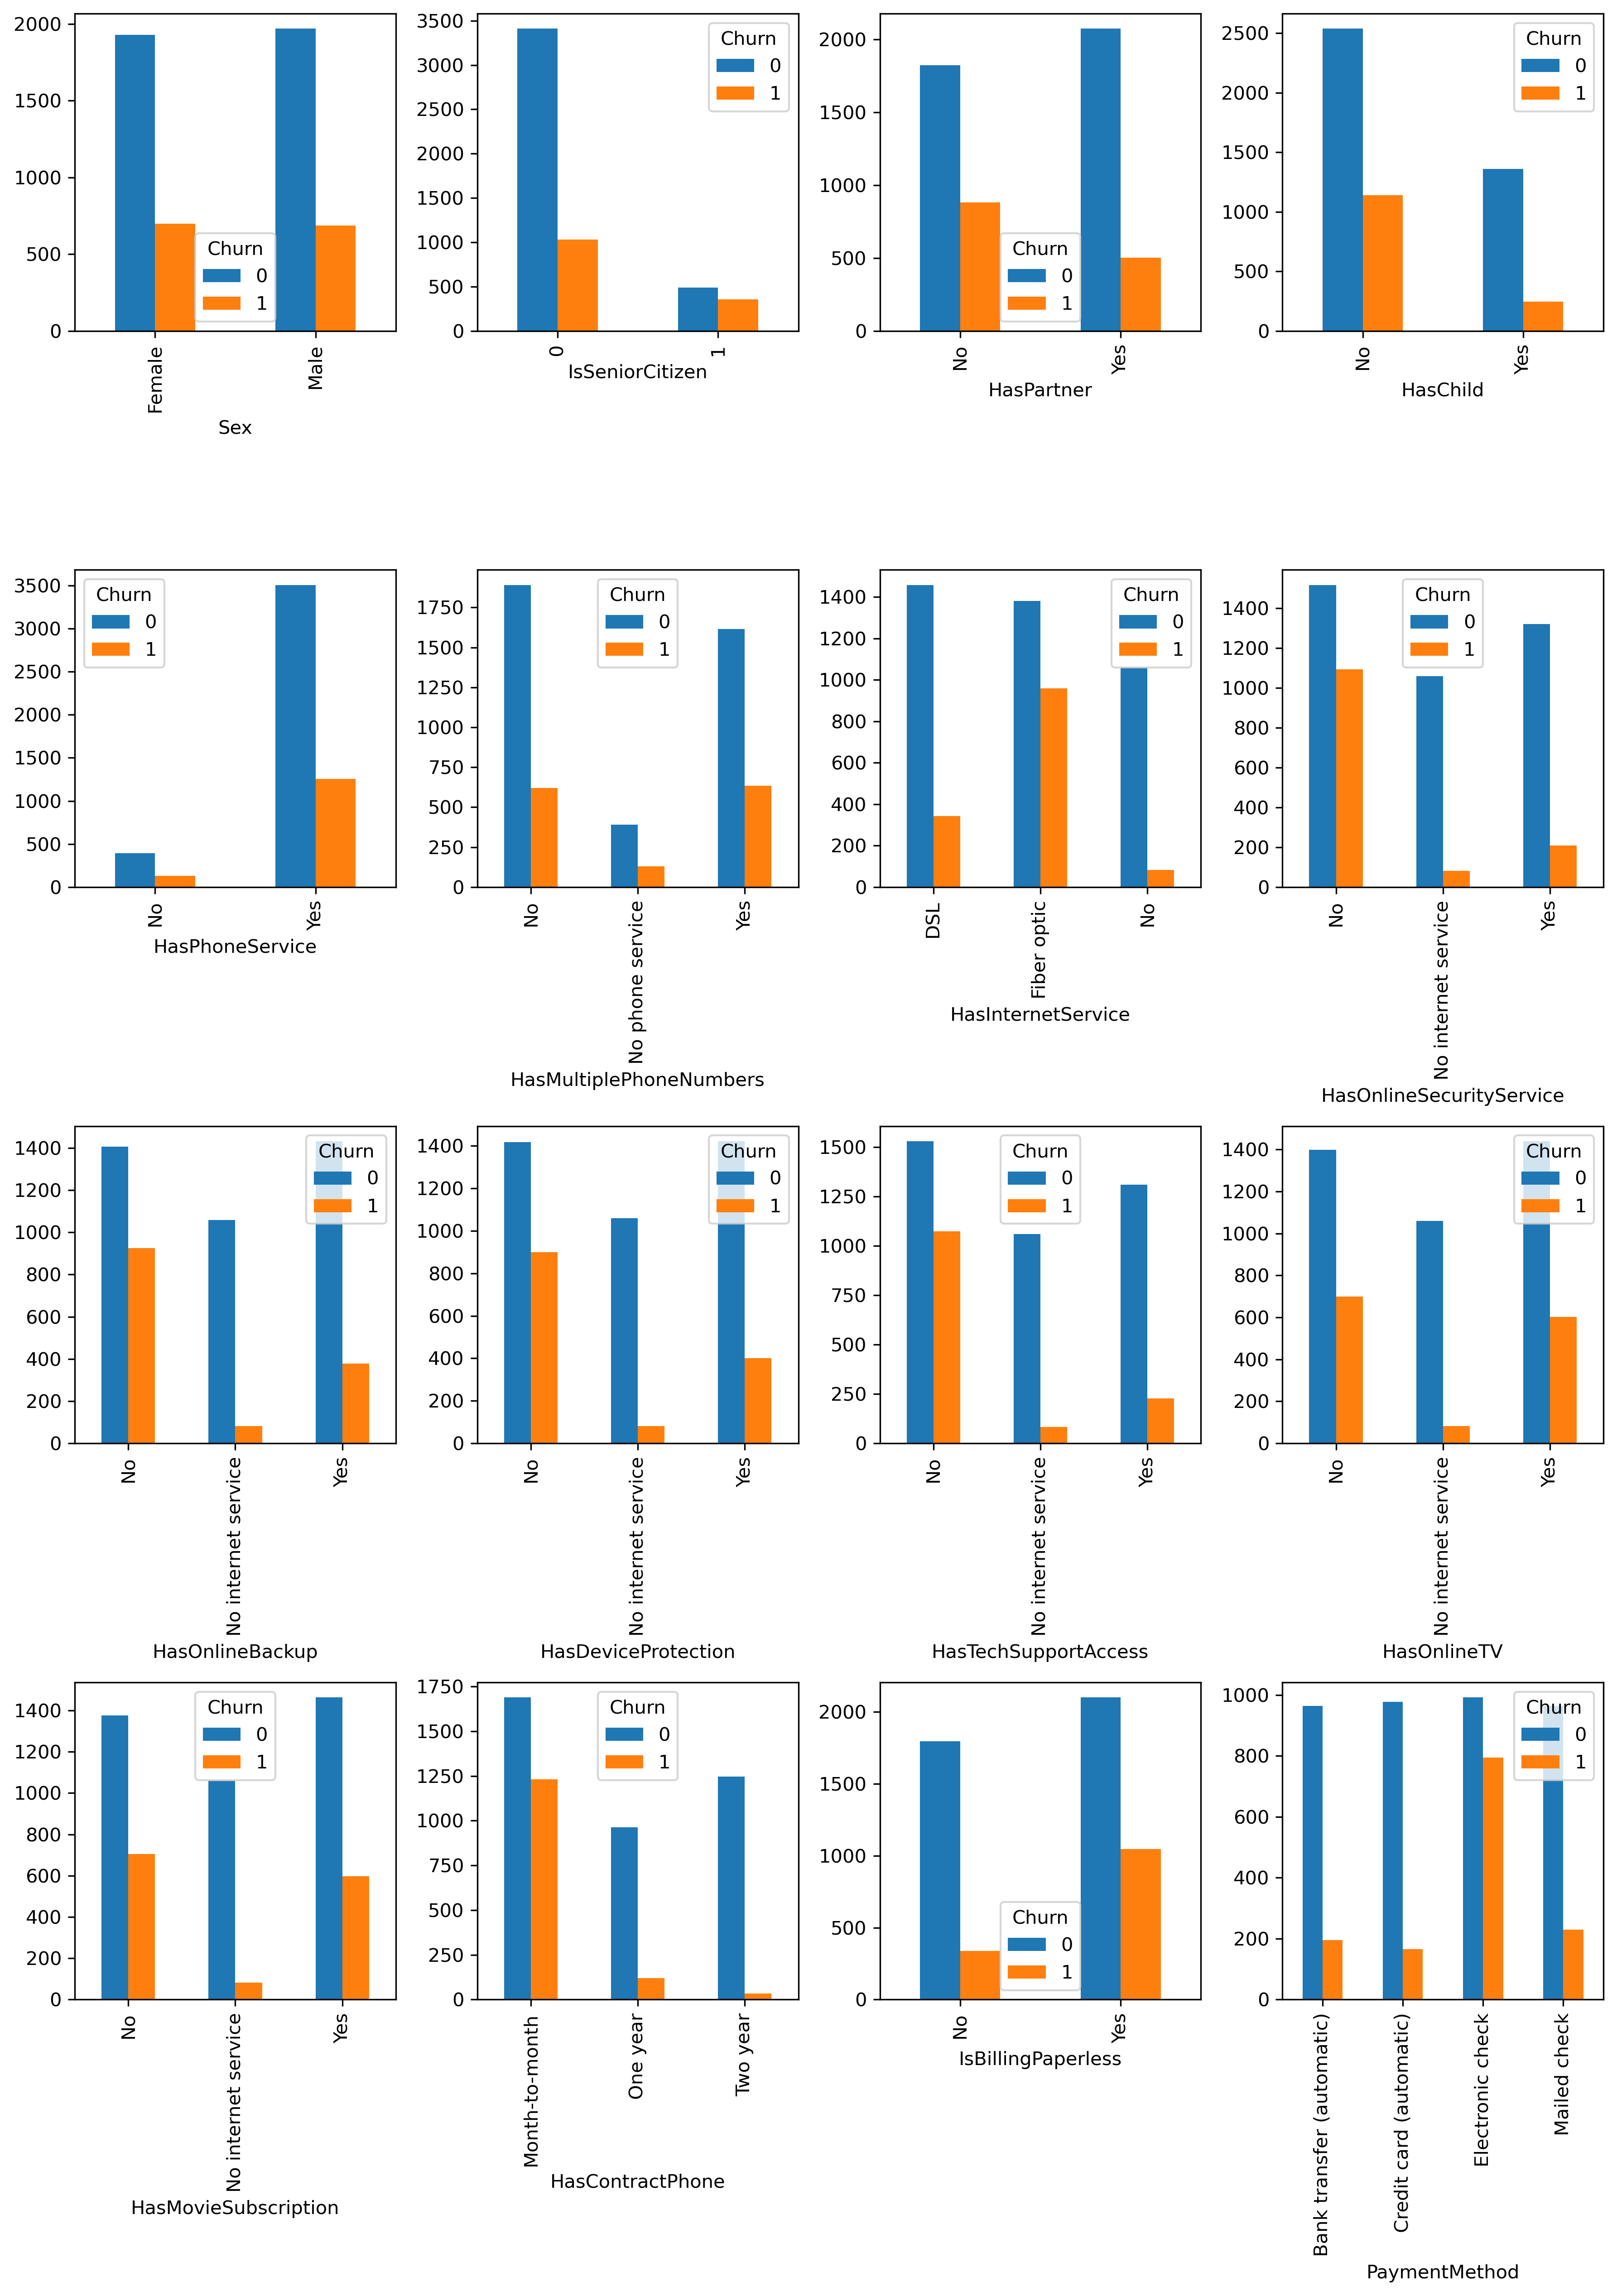

In [10]:
colors = {0:'tab:blue', 1:'tab:orange'}
fig, axs = plt.subplots(4, 4, figsize=(12, 17), dpi=300)

for idx, one_column in enumerate(cat_cols):
    pd.crosstab(data[one_column],data['Churn']).plot.bar(ax=axs[idx//4, idx % 4])
fig.tight_layout()

plt.show()


In [11]:
data[cat_cols].apply(lambda x: x.value_counts(normalize=True)).T.stack()


Sex                       Female                       0.497349
                          Male                         0.502651
IsSeniorCitizen           0                            0.840591
                          1                            0.159409
HasPartner                No                           0.512117
                          Yes                          0.487883
HasChild                  No                           0.695949
                          Yes                          0.304051
HasPhoneService           No                           0.098637
                          Yes                          0.901363
HasMultiplePhoneNumbers   No                           0.475388
                          No phone service             0.098637
                          Yes                          0.425975
HasInternetService        DSL                          0.340780
                          Fiber optic                  0.443203
                          No            

(Дополнительно) Если вы нашли какие-то ошибки в данных или выбросы, то можете их убрать. Тут можно поэксперементировать с обработкой данных как угодно, но не за баллы.

In [12]:
pt = PowerTransformer()
data_exp = data.copy()
data_exp[num_cols] = pt.fit_transform(data_exp[num_cols])

У числовых признаков был разный масштаб и они выглыдели не нормально распределенными, применим к ним степенную трансформацию. Тут делаю на отдельном датафрейме, но дальше сделаю это в пайплайне обработки.

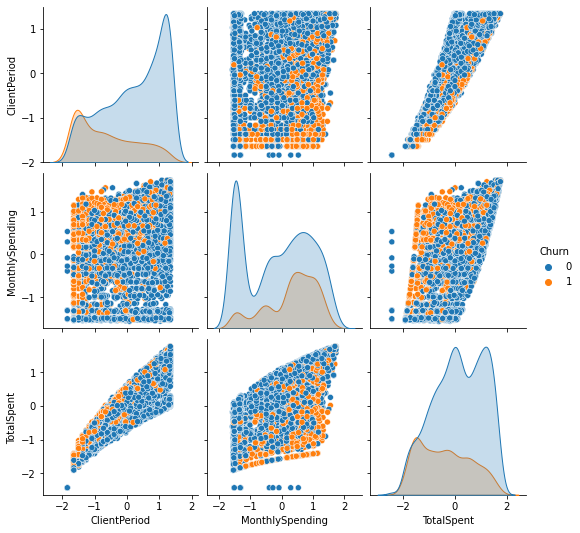

In [13]:
sns.pairplot(data_exp[[*num_cols, 'Churn']], hue='Churn')

## Применение линейных моделей (3 балла)

1) Обработайте данные для того, чтобы к ним можно было применить LogisticRegression. Т.е. отнормируйте числовые признаки, а категориальные закодируйте с помощью one-hot-encoding'а. 

2) С помощью кроссвалидации или разделения на train/valid выборку протестируйте разные значения гиперпараметра C и выберите лучший (можно тестировать С=100, 10, 1, 0.1, 0.01, 0.001) по метрике ROC-AUC. 

Если вы разделяете на train/valid, то используйте LogisticRegressionCV. Он сам при вызове .fit() подберет параметр С. (не забудьте передать scroing='roc_auc', чтобы при кроссвалидации сравнивались значения этой метрики, и refit=True, чтобы при потом модель обучилась на всем датасете с лучшим параметром C). 


(более сложный вариант) Если вы будете использовать кроссвалидацию, то преобразования данных и LogisticRegression нужно соединить в один Pipeline с помощью make_pipeline, как это делалось во втором семинаре. Потом pipeline надо передать в GridSearchCV. Для one-hot-encoding'a можно испльзовать комбинацию LabelEncoder + OneHotEncoder (сначала превращаем строчки в числа, а потом числа првращаем в one-hot вектора.)

In [14]:
numeric_transformer = Pipeline(
    steps=[("power_transformer", PowerTransformer())]
)

categorical_transformer = OneHotEncoder(handle_unknown="ignore")

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols),
    ]
)
clf = make_pipeline( preprocessor, LogisticRegression(solver='saga'))

set_config(display="diagram")
clf

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('power_transformer',
                                                                   PowerTransformer())]),
                                                  ['ClientPeriod',
                                                   'MonthlySpending',
                                                   'TotalSpent']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Sex', 'IsSeniorCitizen',
                                                   'HasPartner', 'HasChild',
                                                   'HasPhoneService',
                                                   'HasMultiplePhoneNumbers',
                                                   'HasInternetService',
                                                   'HasOnlineSecurityService',
                                                   'HasOnlineBackup',
                                                   'HasDeviceProtection',
                                                   'HasTechSupportAccess',
                                                   'HasOnlineTV',
                                                   'HasMovieSubscription',
                                                   'HasContractPhone',
                                                   'IsBillingPaperless',
                                                   'PaymentMethod'])])),
                ('logisticregression', LogisticRegression(solver='saga'))])

In [15]:
X_train = data.drop(columns='Churn')
y_train = data['Churn']

In [16]:
parameters = {'logisticregression__penalty':('l1', 'l2'), 'logisticregression__C':np.logspace(-2, 2)}
search = GridSearchCV(clf, parameters, scoring='roc_auc', n_jobs=-1)
search.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('power_transformer',
                                                                                          PowerTransformer())]),
                                                                         ['ClientPeriod',
                                                                          'MonthlySpending',
                                                                          'TotalSpent']),
                                                                        ('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['Sex',
                                                                          'IsSeniorCitizen',
                                                                          'HasPartner',
                                                                          'HasChild',
                                                                          'HasPhoneService',
                                                                          'HasMultiplePhoneNumbers',
                                                                          'Has...
       1.93069773e+00, 2.32995181e+00, 2.81176870e+00, 3.39322177e+00,
       4.09491506e+00, 4.94171336e+00, 5.96362332e+00, 7.19685673e+00,
       8.68511374e+00, 1.04811313e+01, 1.26485522e+01, 1.52641797e+01,
       1.84206997e+01, 2.22299648e+01, 2.68269580e+01, 3.23745754e+01,
       3.90693994e+01, 4.71486636e+01, 5.68986603e+01, 6.86648845e+01,
       8.28642773e+01, 1.00000000e+02]),
                         'logisticregression__penalty': ('l1', 'l2')},
             scoring='roc_auc')

In [17]:
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

Best parameter (CV score=0.848):
{'logisticregression__C': 0.2442053094548651, 'logisticregression__penalty': 'l1'}


In [18]:
roc_auc_score(y_train, search.predict(X_train))

0.7204774866019924

Выпишите какое лучшее качество и с какими параметрами вам удалось получить

получилось достичь ROC_AUC = 0.7205 с параметрами {'logisticregression__C': 0.2442053094548651, 'logisticregression__penalty': 'l1'}

## Применение градиентного бустинга (2 балла)

Если вы хотите получить баллы за точный ответ, то стоит попробовать градиентный бустинг. Часто градиентный бустинг с дефолтными параметрами даст вам 80% результата за 0% усилий.

Мы будем использовать catboost, поэтому нам не надо кодировать категориальные признаки. catboost сделает это сам (в .fit() надо передать cat_features=cat_cols). А численные признаки нормировать для моделей, основанных на деревьях не нужно.

1) Разделите выборку на train/valid. Протестируйте catboost cо стандартными параметрами.

2) Протестируйте разные занчения параметроа количества деревьев и learning_rate'а и выберите лучшую по метрике ROC-AUC комбинацию. 

(Дополнительно) Есть некоторые сложности с тем, чтобы использовать CatBoostClassifier вместе с GridSearchCV, поэтому мы не просим использовать кроссвалидацию. Но можете попробовать)

In [23]:
X_train_split, X_val, y_train_split, y_val = train_test_split(X_train, y_train, 
                                                       train_size=0.7)

In [35]:
boosting_model = catboost.CatBoostClassifier(n_estimators=200, silent=True,
                                             cat_features=cat_cols,
                                             eval_metric='AUC')

grid = {'depth': [4, 6, 10],
        'l2_leaf_reg': np.linspace(0, 1, 20)}

grid_search_result = boosting_model.grid_search(grid, 
                           X_train_split, 
                           y_train_split, plot=True, refit=True)

y_train_predicted = boosting_model.predict_proba(X_train_split)[:, 1]
y_test_predicted = boosting_model.predict_proba(X_val)[:, 1]

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


bestTest = 0.8180190825
bestIteration = 198

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
0:	loss: 0.8180191	best: 0.8180191 (0)	total: 3.97s	remaining: 3m 54s

bestTest = 0.8166287623
bestIteration = 197

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
1:	loss: 0.8166288	best: 0.8180191 (0)	total: 5.29s	remaining: 2m 33s

bestTest = 0.8179524537
bestIteration = 168

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
2:	loss: 0.8179525	best: 0.8180191 (0)	total: 6.94s	remaining: 2m 11s

bestTest = 0.8189252336
bestIteration = 194

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
3:	loss: 0.8189252	best: 0.8189252 (3)	total: 8.1s	remaining: 1m 53s



In [47]:
boosting_model.fit(X_train, y_train)

In [36]:
grid_search_result

{'params': {'depth': 4, 'l2_leaf_reg': 0.894736842105263},
 'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31,
               32,
               33,
               34,
               35,
               36,
               37,
               38,
               39,
               40,
               41,
               42,
               43,
               44,
               45,
               46,
           

In [37]:
roc_auc_score(y_val, y_test_predicted)

0.8544800673030468

Выпишите какое лучшее качество и с какими параметрами вам удалось получить

покрутив параметр глубины дерева и регуляризации, получилось на значениях {'depth': 4, 'l2_leaf_reg': 0.894736842105263} получить ROC_AUC 0.8545

# Предсказания

In [41]:
# best_model = search
best_model = boosting_model

In [44]:
X_test = pd.read_csv('test.csv')
X_test.TotalSpent = pd.to_numeric(X_test.TotalSpent.replace(" ", 0))
submission = pd.read_csv('submission.csv')

submission['Churn'] = best_model.predict_proba(X_test)[:,1]
submission.to_csv('my_submission.csv', index=False)

# Kaggle (5 баллов)

Как выставить баллы:

1) 1 >= roc auc > 0.84 это 5 баллов

2) 0.84 >= roc auc > 0.7 это 3 балла

3) 0.7 >= roc auc > 0.6 это 1 балл

4) 0.6 >= roc auc это 0 баллов


Для выполнения задания необходимо выполнить следующие шаги.
* Зарегистрироваться на платформе [kaggle.com](kaggle.com). Процесс выставления оценок будет проходить при подведении итогового рейтинга. Пожалуйста, укажите во вкладке Team -> Team name свои имя и фамилию в формате Имя_Фамилия (важно, чтобы имя и фамилия совпадали с данными на Stepik).
* Обучить модель, получить файл с ответами в формате .csv и сдать его в конкурс. Пробуйте и экспериментируйте. Обратите внимание, что вы можете выполнять до 20 попыток сдачи на kaggle в день.
* После окончания соревнования отправить в итоговый ноутбук с решением на степик. 
* После дедлайна проверьте посылки других участников по критериям. Для этого надо зайти на степик, скачать их ноутбук и проверить скор в соревновании.